### Large-Scale Sparse SVD Subspace Pursuit

This notebook implements PCA (one-sided singular values of a matrix) with an L0 constraint of the subset of rows/features (k). The step of updating the subdata to rank k+q (q=1 in this project), then greedily trimming q rows, was motivated by SASR simulated annealing (Du 2014). However, the state of a single matrix going under serialized mutations in that paper was not desirable. A linear algebra library would have low utilization of the CPU, let alone GPU, for the small SVDs being done in serial.

Du et al had a uniform distribution of features that can be updated in the subdata, whereas we should continuously histogram the performance of each feature in the current subdatas and start trimming features. We can spend much time making rough k+1 SVD updates on every single possible feature, without re-running SVD (Ross 2008). This quickly fills up a histogram of which features are being selected above some minimum criteria.

The metric for retaining a feature (out of k+1 features) is the percentage of variance explained by the feature in the most significant D eigenvectors (k, d, are parameters). This is the L2 norm of the k'th coordinate in the D left singular values. For now, when the user selects D > 1 during feature selection, we don't rescale this performance criteria by variance (it is fidelity along Mahalanobis distance).

#### References

Du, Xinpeng, Lizhi Cheng, and Daiqiang Chen. "A simulated annealing algorithm for sparse recovery by l0 minimization." Neurocomputing 131 (2014): 98-104.

Ross, D. A., Lim, J., Lin, R. S., & Yang, M. H. (2008). Incremental learning for robust visual tracking. International journal of computer vision, 77(1), 125-141.

In [74]:
import tensorflow as tf

In [75]:
data = tf.random.normal((20, 100))

In [76]:
# Subsets of the data.
matrices = tf.gather(
    data,
    tf.reshape(tf.random.shuffle(tf.range(data.shape[0]))[:15], (5, 3))
)
s, u, v = tf.linalg.svd(matrices)
matrices.shape

TensorShape([5, 3, 100])

In [77]:
v.shape

TensorShape([5, 100, 3])

In [78]:
u[0]

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[ 0.856, -0.493,  0.156],
       [-0.142,  0.066,  0.988],
       [-0.497, -0.868, -0.013]], dtype=float32)>

In [79]:
augmented_data = tf.gather(
    data,
    tf.random.shuffle(tf.range(data.shape[0]))[:10]
)

In [80]:
exact_augmented_shape = [5, 10, 3, 100]
s_aug_exact, u_aug_exact, v_aug_exact = tf.linalg.svd(
    tf.concat(
        [
            tf.broadcast_to(matrices[:, None, :, :], exact_augmented_shape),
            tf.broadcast_to(augmented_data[None, :, None, :], [5, 10, 1, 100]),
        ],
        axis=2
    )
)

In [81]:
s[0]

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([10.547, 10.239,  9.165], dtype=float32)>

In [82]:
s_aug_exact[0, 1]

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([10.624, 10.265,  9.437,  8.354], dtype=float32)>

In [85]:
import tensorflow_probability as tfp

@tf.function(jit_compile = True)
def transpose_simple(matrices):
    """Transpose utility for batches of matrices (high-dimensional)."""
    ndim = len(matrices.shape)
    return tf.transpose(matrices, list(range(ndim-2)) + [ndim-1, ndim-2])

@tf.function(jit_compile = True)
def create_block_diagonal_augmented_u(svd_u):
    """Treat the batch of u matrices as being updated block diagonally.

    The orthonormal basis is trivial on the left side at this point, when
    adding a new row. The existing basis is zero along this dimension, and
    we produce an orthonormal basis vector e_N. Then, the augmented matrix
    SVD would need a V with a more sophisticated basis vector, but we
    discard V in this algorithm.
    
    The new SVD factorization's left singular vectors are found by
    multiplying this trivial matrix by the left singular vectors of the
    "augmented S".
    """
    augmented_pca_u = tf.concat(
        [
            tf.concat(
                [
                    svd_u,
                    tf.zeros(svd_u.shape[:-1] + (1,)),
                ],
                axis=-1,
            ),
            tf.concat(
                [
                    tf.zeros(svd_u.shape[:-2] + (1, svd_u.shape[-1])),
                    tf.ones(svd_u.shape[:-2] + (1, 1)),
                ],
                axis=-1,
            ),
        ],
        axis=-2,
    )
    return augmented_pca_u

@tf.function(jit_compile = True)
def build_update_s_matrix_blocks(svd_s, svd_u, svd_v, possible_rows):
    # Add a row to the SVD decomposition by adding to S*V^T:
    # encoding^T * V + ortho_norm * orthogonalize(V, row)
    # encoding is the vector of the projection of row onto each
    # basis vector in V. The orthogonalize function would subtract
    # the projection onto this column space from row, then save the
    # norm of the resulting normalized vector. The norm goes into S.
    # U is updated with a 1 (add a diagonal block for the identity matrix 1x1).
    # This is the transpose of the single-column update given by Ross 2008.
    # Ross, D. A., Lim, J., Lin, R. S., & Yang, M. H. (2008). Incremental learning for robust visual tracking. International journal of computer vision, 77(1), 125-141.
    n_matrices = svd_s.shape[0]
    n_observations = svd_v.shape[1]
    n_outputs = possible_rows.shape[0]
    feature_k = svd_s.shape[1]
    s_21 = tf.linalg.matmul(possible_rows[None, :, :], svd_v)[:, :, None, :]
    proj_rows_batch_shape = [n_matrices, n_outputs, 1, feature_k]
    transpose_v_batch_shape = [n_matrices, n_outputs, feature_k, n_observations]
    # Note: A projection matrix onto the right-singular vectors is:
    # `svd_v * svd_v^T` (unlike NumPy, "v" return value is not transposed).
    # svd_v contains precisely the eigenvectors of M^T M in columns. We
    # transpose the entire expression projecting our input vectors (which are
    # row vectors). Then, we use the already-computed s_21 and possible_rows.
    # `svd_v * svd_v^T * ColVecs = (RowVecs * svd_v * svd_v^T)^T`
    row_projection = tf.squeeze(
        tf.linalg.matmul(
            s_21,
            transpose_simple(svd_v)[:, None, :, :]),
        axis=2)
    row_ortho = possible_rows[None, :, :] - row_projection
    # row_ortho would be used as a new right-singular vector in V, but we are
    # discarding V. It must be unit-scaled.
    row_ortho = tf.linalg.normalize(row_ortho)[0]
    # Now find the extent of the original data along the orthogonal basis vector.
    s_22 = tf.linalg.matmul(row_ortho[:, :, None, :], possible_rows[None, :, :, None])
    # matmul creates 1x1 matrices, so we extract the scalar value.
    s_22 = s_22[:, :, 0, 0]
    return s_21, s_22

@tf.function(jit_compile = True)
def approximate_update_eigenvalues(svd_s, s_22):
    """Initialization for augmented matrix power iteration.
    
    Augmented S is no longer a diagonal matrix, so the eigenvalues
    are perturbed from the original matrix. Generally, the update
    to the matrix trace is small, and the final eigenvalue is even
    smaller than the final diagonal entry that we append. We can
    divide up the final value of S^2 arbitrarily, and add some of
    that contribution uniformly to the larger eigenvalues, while the
    final eigenvalue will be very small.
    """
    feature_k = svd_s.shape[1]
    aug_contribution = tf.square(s_22) / 2. / feature_k
    return tf.concat([tf.square(svd_s)[:, None, :] + aug_contribution[:, :, None], (tf.square(s_22) / 2.)[:, :, None]], axis=-1)

# TODO: We are close to not needing to create these augmented matrices explicitly.
@tf.function(jit_compile = True)
def build_augmented_s(svd_s, s_21, s_22):
    """Augment S for k+1 rows - no longer a diagonal matrix."""
    b1 = s_21.shape[0]
    b2 = s_21.shape[1]
    feature_k = svd_s.shape[1]
    return tf.concat(
        [
            tf.concat(
                [
                    tf.broadcast_to(
                        tf.linalg.diag(svd_s)[:, None, :, :],
                        [b1, b2, feature_k, feature_k]),
                    tf.zeros((b1, b2, feature_k, 1)),
                ],
                axis=-1,
            ),
            tf.concat(
                [
                    s_21,
                    s_22[:, :, None, None],
                ],
                axis=-1
            ),
        ],
        axis=-2,
    )

@tf.function(jit_compile = True)
def build_augmented_psd(svd_s, s_21, s_22):
    """Build AugS * AugS^T."""
    b1 = s_21.shape[0]
    b2 = s_21.shape[1]
    feature_k = svd_s.shape[1]
    return tf.concat(
        [
            tf.concat(
                [
                    tf.broadcast_to(
                        tf.linalg.diag(tf.square(svd_s))[:, None, :, :],
                        [b1, b2, feature_k, feature_k]),
                    transpose_simple(s_21 * svd_s[:, None, None, :]),
                ],
                axis=-1,
            ),
            tf.concat(
                [
                    s_21 * svd_s[:, None, None, :],
                    tf.square(s_22)[:, :, None, None],
                ],
                axis=-1
            ),
        ],
        axis=-2,
    )

@tf.function(jit_compile = True)
def approximate_eigen0_power_iteration(svd_s, s_21, s_22, niter=3):
    """Power iteration algorithm for a blocked Cholesky matrix.
    
    AugS is represented by [[svd_s, 0], [s_21, s_22]], so we can derive
    AugS * AugS^T and search for its largest eigenvalue. This is initialized
    from the first column of AugS * AugS^T, which has large values in it
    (initial guess).
    """
    b1 = s_21.shape[0]
    b2 = s_21.shape[1]
    feature_k = s_21.shape[-1]
    ev = tf.concat(
        [
            tf.broadcast_to(
                svd_s[:, None, 0:1],
                [b1, b2, 1]),
            tf.zeros((b1, b2, feature_k - 1)),
            svd_s[:, None, 0:1] * s_21[:, :, 0, 0:1],
        ],
        axis=-1,
    )
    ev = ev[:, :, :, None]
    ev = tf.linalg.normalize(ev)[0]
    ev_lambda = None
    # TODO: Benchmark multiplying each block manually, no new
    # matrix creation here.
    psd_matrix = build_augmented_psd(svd_s, s_21, s_22)
    for i in range(niter):
        ev = tf.linalg.matmul(psd_matrix, ev)
        ev, ev_lambda = tf.linalg.normalize(ev, axis=2)
    return ev, ev_lambda[:, :, 0, 0]

@tf.function(jit_compile = True)
def approximate_eigenvalue_power_iteration(svd_s, s_21, s_22, eigenvectors):
    """Single-iteration power iteration for multiple eigenvalues.

    The largest eigenvalue should use a for-loop power iteration for fidelity.
    Here, we apply the matrix once and project back onto the best-guess eigenvector
    (avoiding the eigenvector of the largest and smallest eigenvalues). The
    smallest eigenvalue/eigenvector is not useful to us.
    """
    b1 = s_21.shape[0]
    b2 = s_21.shape[1]
    feature_k = s_21.shape[-1]
    augmented_s = build_augmented_s(svd_s, s_21, s_22)
    augmented_psd = tf.linalg.matmul(augmented_s, transpose_simple(augmented_s))
    result = tf.linalg.matmul(augmented_psd, eigenvectors)
    eigenvectors = tfp.math.gram_schmidt(result)
    result = tf.linalg.matmul(augmented_psd, eigenvectors)
    def norm_power_result(eig_index):
        indexed_eigenvectors = eigenvectors[:, :, :, eig_index:eig_index + 1]
        def make_projection_matrix():
            return tf.linalg.matmul(indexed_eigenvectors, transpose_simple(indexed_eigenvectors))
        def make_identity_matrix():
            return tf.broadcast_to(
                tf.linalg.eye(feature_k + 1)[None, None, :, :],
                [b1, b2, feature_k + 1, feature_k + 1])
        # TODO: Already added separate function for eigen0 so remove tf.cond.
        result_projection = tf.linalg.matmul(
            tf.cond(
                tf.greater(eig_index, 0),
                make_projection_matrix,
                make_identity_matrix),
            result[:, :, :, eig_index:eig_index + 1])
        result_projection = result_projection[:, :, :, 0]
        return tf.linalg.norm(result_projection, axis=2)
    # These skip the lambda0 which should use repeated power iteration.
    # lambda0 greatly affects the Gram Schmidt process so it needs to be high quality.
    # Also, we guess that eigenvector using the first column of AugS*AugS^T.
    eigenvalues = tf.map_fn(
        norm_power_result,
        tf.range(1, eigenvectors.shape[-1]),
        fn_output_signature=tf.float32,
    )
    eigenvalues = tf.transpose(eigenvalues, [1, 2, 0])
    eigenvalues = tf.concat(
        [
            approximate_eigen0_power_iteration(svd_s, s_21, s_22)[1][:, :, None],
            eigenvalues,
        ],
        axis=2
    )
    trace_original = tf.math.reduce_sum(tf.square(svd_s), axis=-1)[:, None]
    trace_aug_missing_final = tf.math.reduce_sum(eigenvalues, axis=-1)
    final_eigenvalue = trace_original + tf.square(s_22) - trace_aug_missing_final
    return tf.concat(
        [
            eigenvalues,
            final_eigenvalue[:, :, None],
        ],
        axis=-1
    )

# TODO: Can we use a Cholesky-like (svd_s - sqrt(lambda) I) * (svd_s - sqrt(lambda) I)^T?
# Write a more typical solver for this.
@tf.function(jit_compile = True)
def solve_update_s_factorization_iteration(svd_s, s_21, s_22, eig):
    """Block Cholesky eigenvector solver for a sparse matrix.
    
    This solution works because all rows but the last row of `AugS * AugS^T`
    have only the diagonal entry and last column which are strictly non-zero.
    
    We want an SVD factorization of AugS so that we end up with the factors
    of an orthonormal U and a diagonal S (V will be discarded). Equivalently,
    we want the eigenvalues and eigenvectors of `AugS * AugS^T`. For the rows
    of `AugS * AugS^T` to be solvable for the eigenvector, then covariance in
    the data matrices should generally be nonzero so that every eigenvalue is
    perturbed.
    
    Suppose `AugS * AugS^T * v = lambda * v`, and `v[-1] = 1`. We compute the
    diagonal and last entry of `AugS * AugS^T` for this row. lambda_i may be
    very close to `(AugS * AugS^T)[i, i]`, so that row is ignored in the solver.
    ev_i is solved using the last row of the matrix, after all other entries
    are solved.
    """
    feature_k = svd_s.shape[1]

    # We will create orthonormal matrices, with eigenvectors in columns. The
    # shape is updated to (b1, b2, feature_k, feature_k - 1). This solver
    # breaks down when it comes to the final (generally smallest) eigenvalue.
    diag_entry = tf.square(svd_s[:, None, :, None]) - eig[:, :, None, :-1]
    # The last column comes from the product of the original s diagonal and the
    # appended row s_21.
    final_entry = svd_s[:, None, :] * s_21[:, :, 0, :]

    def solve_ev(eig_index):
        entries_before = final_entry[:, :, :eig_index] / diag_entry[:, :, :eig_index, eig_index]
        entries_after = final_entry[:, :, eig_index + 1:] / diag_entry[:, :, eig_index + 1:, eig_index]
        this_entry = (
                tf.math.reduce_sum(
                    final_entry[:, :, :eig_index] * entries_before,
                    axis=-1)
                + tf.math.reduce_sum(
                    final_entry[:, :, eig_index + 1:] * entries_after,
                    axis=-1)
                + (tf.square(s_22) - eig[:, :, eig_index]) * 1.
            )[:, :, None] / -final_entry[:, :, eig_index:eig_index + 1]
        return tf.concat(
            [
                entries_before,
                this_entry,
                entries_after,
                tf.ones_like(this_entry),
            ],
            axis=-1
        )

    eigenvectors = tf.concat(
        #[approximate_eigen0_power_iteration(svd_s, s_21, s_22)[0]]
        #+
        [
            solve_ev(eig_index)[:, :, :, None]
            for eig_index in range(int(feature_k))
        ],
        axis=3,
    )
    return tfp.math.gram_schmidt(eigenvectors)

In [86]:
s_21, s_22 = build_update_s_matrix_blocks(s, u, v, augmented_data)
s_21.shape

TensorShape([5, 10, 1, 3])

In [87]:
augmented_s = build_augmented_s(s, s_21, s_22)
augmented_psd = tf.linalg.matmul(augmented_s, transpose_simple(augmented_s))
augmented_psd_lambda_actual, augmented_psd_ev_actual = tf.linalg.eigh(augmented_psd)
augmented_psd_lambda_actual = augmented_psd_lambda_actual[:, :, ::-1]
augmented_psd_ev_actual = augmented_psd_ev_actual[:, :, :, ::-1]
augmented_psd_lambda_actual[0, 0]

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([111.255, 105.121,  85.197,   1.751], dtype=float32)>

In [88]:
import numpy as np
ev = solve_update_s_factorization_iteration(s, s_21, s_22, approximate_update_eigenvalues(s, s_22))
np.quantile(np.abs((ev * augmented_psd_ev_actual[:, :, :, :-1]).numpy().sum(axis=-2)), [0.01, 0.1, 0.25, 0.5, 0.9])

array([0.039, 0.557, 0.96 , 0.996, 1.   ])

In [14]:
ev_lambda = approximate_eigenvalue_power_iteration(s, s_21, s_22, ev)
ev_lambda[0, 0]

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([113.24056  , 102.12055  ,  84.85995  ,   1.7277527], dtype=float32)>

In [15]:
ev = solve_update_s_factorization_iteration(s, s_21, s_22, ev_lambda)
np.quantile(np.abs((ev * augmented_psd_ev_actual[:, :, :, :-1]).numpy().sum(axis=-2)), [0.01, 0.1, 0.25, 0.5, 0.9])

array([0.0880382 , 0.89206724, 0.98316965, 0.99740428, 0.99993255])

Note: Deleted some copies of these 2 cells. After this point, the iterations could not arrive any closer to the eigenvectors.

The 90%ile approximate eigenvector (largest eigenvalue, PCA PC_1) error looks poor. For now, the rank-1 update is used for generating many mutations of the data and for building a histogram. Hopefully it does not bias us to trim some rows that might perform well, if we gave them a full k+1 SVD.

### Feature Statistics

We can generate a large number of SVDs of k+1-feature subsets of the data. The k+1'th feature (augmented to the original SVD) either outperforms the k'th ranked feature, or the new feature is rejected from this submatrix of data. The binary choice should be summed up over many rounds.

In [16]:
MAX_SAMPLED_ELEMENTS = 256

@tf.function(jit_compile = True)
def generate_random_ensemble(data, k):
    num_samples = min(MAX_SAMPLED_ELEMENTS, data.shape[0]) // k
    feature_inds = tf.reshape(tf.random.shuffle(tf.range(data.shape[0]))[:num_samples * k], (num_samples, k))
    return tf.sort(feature_inds, axis=1)

@tf.function(jit_compile = True)
def evaluate_features_batch(data, k, ndim, feature_inds=None):
    if feature_inds is None:
        feature_inds = generate_random_ensemble(data, k)
    matrices = tf.gather(data, feature_inds)
    s, u, v = tf.linalg.svd(matrices)
    s_21, s_22 = build_update_s_matrix_blocks(s, u, v, data)
    
    ev_rotate = solve_update_s_factorization_iteration(
        s, s_21, s_22, approximate_update_eigenvalues(s, s_22))
    ev_lambda = approximate_eigenvalue_power_iteration(s, s_21, s_22, ev_rotate)
    ev_rotate = solve_update_s_factorization_iteration(s, s_21, s_22, ev_lambda)
    # The eigenvectors of the updated triangular matrix are a rotation of the eigenvectors
    # of the original svd. u simply needs to be updated with a 1 on the diagonal; this is
    # the orthogonal basis that we are using for k+1.
    augmented_pca_u = tf.concat(
        [
            tf.concat(
                [
                    u,
                    tf.zeros(u.shape[:-1] + (1,)),
                ],
                axis=-1,
            ),
            tf.concat(
                [
                    tf.zeros(u.shape[:-2] + (1, u.shape[-1])),
                    tf.ones_like(u)[..., 0:1, 0:1],
                ],
                axis=-1,
            ),
        ],
        axis=-2,
    )
    ev = tf.linalg.matmul(augmented_pca_u[:, None, :, :], ev_rotate)

    feature_performance = tf.linalg.norm(
        ev[:, :, :, :ndim], axis=3,
    )
    data_selected = tf.cast(
        feature_performance[:, :, k] > tf.math.reduce_min(feature_performance[:, :, :k], axis=2),
        tf.int32,
    )

    data_conflict = tf.reduce_any(
        tf.range(data.shape[0])[None, :, None] == feature_inds[:, None, :],
        axis=2,
    )
    data_selected = tf.where(data_conflict, tf.constant(0), data_selected)
    return tf.math.reduce_sum(data_selected, axis=0)

In [17]:
@tf.function(jit_compile = True)
def evaluate_features_round(data, k, ndim, num_batches=10):
    # TODO: parallel_iterations is not actually affecting latency in eager mode.
    results = tf.map_fn(
        lambda i: evaluate_features_batch(data, k, ndim),
        tf.range(num_batches),
        fn_output_signature=tf.int32,
        parallel_iterations=1,
    )
    return tf.math.reduce_sum(results, axis=0)

In [18]:
# Real developmental biology sc-RNAseq data (embryonic mouse nervous tissue)
import numpy as np
data = np.loadtxt('BuettnerEtAl2015.csv', delimiter=',', dtype='object')
gene_names = data[1:, 0]
data = data[1:, 1:].astype(int)
cdata = data.astype(float) - np.mean(data, axis=1)[:, None]
cdata_std = np.std(cdata, axis=1)
cdata /= np.maximum(1e-20, cdata_std[:, None])
var_genes = np.sort(np.argsort(-cdata_std)[:5000])
gene_names = gene_names[var_genes]
cdata = cdata[var_genes]

cdata = tf.constant(cdata, tf.float32)

In [19]:
bins = evaluate_features_round(cdata, 3, 1)

2022-10-22 12:00:30.211921: I tensorflow/stream_executor/gpu/asm_compiler.cc:323] ptxas warning : Registers are spilled to local memory in function 'sort_26', 460 bytes spill stores, 396 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'sort_25', 460 bytes spill stores, 396 bytes spill loads



In [20]:
bins

<tf.Tensor: shape=(5000,), dtype=int32, numpy=array([ 54,  98,  43, ...,  50,  63, 230], dtype=int32)>

In [21]:
gene_names[np.argmax(bins)]

'"ENSMUSG00000023944"'

https://www.ncbi.nlm.nih.gov/gene/?term=ENSMUSG00000023944

Hsp90ab1 -> heat shock protein is expressed in central nervous system (axonogenesis). It has functional significance to an embryonic nervous system dataset.

In [22]:
import matplotlib.pyplot as plt

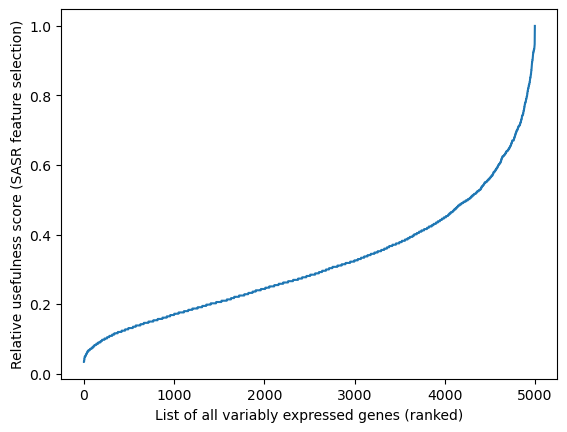

In [23]:
plt.figure()
sorted_bins = np.sort(bins)
plt.plot(sorted_bins / sorted_bins[-1])
plt.xlabel('List of all variably expressed genes (ranked)')
plt.ylabel('Relative usefulness score (SASR feature selection)')
None

In [24]:
np.random.choice(np.arange(cdata.shape[0]), 5000, replace=False, p=tf.linalg.normalize(bins, 1)[0].numpy())

array([ 310, 1551, 1684, ..., 3224, 4714, 1997])

In [25]:
@tf.function
def build_ensemble(data, k, ndim, bins, ensemble_size=8, niter=10):
    def resample_ensemble(size, k, norm_bins):
        ensemble = np.random.choice(
            np.arange(size),
            ensemble_size * k,
            replace=False,
            p=norm_bins)
        ensemble = ensemble.reshape((ensemble_size, k))
        return ensemble
    ensemble = tf.py_function(
        resample_ensemble,
        [data.shape[0], k, tf.linalg.normalize(bins, 1)[0]],
        tf.int32,
    )
    ensemble = tf.ensure_shape(ensemble, [ensemble_size, k])

    @tf.function(jit_compile = True)
    def build_ensemble_xla(data, k, ndim, ensemble):
        def update_element(feature_list):
            augment_selection = evaluate_features_batch(
                data, k, ndim, feature_list[None, :])
            selected_inds = tf.random.shuffle(tf.where(augment_selection)[:, 0])
            def replace_poorly_performing_feature():
                s, u, v = tf.linalg.svd(tf.gather(data, feature_list))
                u_score = tf.linalg.norm(u[:, :ndim], axis=-1)
                poorly_performing_lookup_ind = tf.cast(tf.argmin(u_score), tf.int32)
                new_feature_ind = tf.cast(selected_inds[0], tf.int32)
                return tf.tensor_scatter_nd_update(
                    feature_list,
                    [[poorly_performing_lookup_ind]],
                    [new_feature_ind],
                )
            return tf.cond(
                tf.shape(selected_inds)[0] > 0,
                replace_poorly_performing_feature,
                lambda: feature_list,
            )

        return tf.map_fn(
            update_element,
            ensemble,
        )

    return tf.while_loop(
        lambda ensemble: True,
        lambda ensemble: (build_ensemble_xla(data, k, ndim, ensemble),),
        (ensemble,),
        maximum_iterations=niter,
    )

In [26]:
build_ensemble(cdata, 3, 1, bins, niter=100)

(<tf.Tensor: shape=(8, 3), dtype=int32, numpy=
 array([[1823, 3139, 1549],
        [ 614,  200, 4275],
        [2185, 1317,  210],
        [2834, 2039,  560],
        [4507,   30,  154],
        [1344, 1672, 2835],
        [ 863,  150, 1955],
        [1785, 2781, 1612]], dtype=int32)>,)

In [33]:
def filter_features_for_sasr(data, gene_names, k, ndim, orig_size, quantile_cutoff=0.25):
    scale_factor = np.ceil(orig_size / data.shape[0])
    bins = evaluate_features_round(data, k, ndim, num_batches=5 * scale_factor).numpy()
    sorted_bins = np.sort(bins)
    cutoff = np.quantile(bins, quantile_cutoff)
    if np.quantile(bins, quantile_cutoff) == np.quantile(bins, quantile_cutoff + 0.25):
        return data, gene_names, None
    plt.plot(sorted_bins)
    plt.plot(np.tile([cutoff], len(bins)), color='red')
    return data[bins > cutoff], gene_names[bins > cutoff], bins

2022-10-22 12:01:44.019731: I tensorflow/stream_executor/gpu/asm_compiler.cc:323] ptxas warning : Registers are spilled to local memory in function 'sort_26', 460 bytes spill stores, 396 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'sort_25', 460 bytes spill stores, 396 bytes spill loads



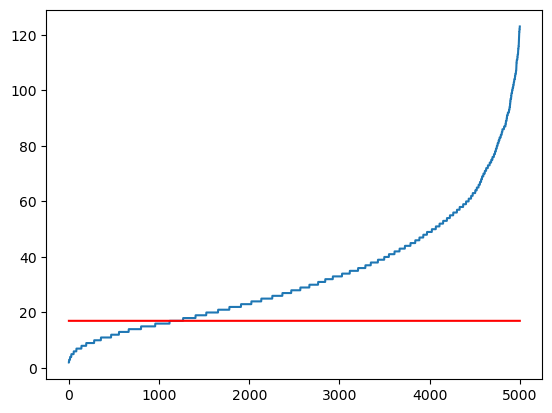

In [34]:
filter_features_for_sasr(cdata, gene_names, 3, 1, len(cdata))
None

2022-10-22 12:01:48.851914: I tensorflow/stream_executor/gpu/asm_compiler.cc:323] ptxas warning : Registers are spilled to local memory in function 'sort_26', 460 bytes spill stores, 396 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'sort_25', 460 bytes spill stores, 396 bytes spill loads



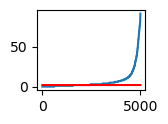

2022-10-22 12:01:55.664316: I tensorflow/stream_executor/gpu/asm_compiler.cc:323] ptxas warning : Registers are spilled to local memory in function 'sort_26', 520 bytes spill stores, 460 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'sort_25', 520 bytes spill stores, 460 bytes spill loads



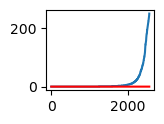

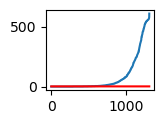

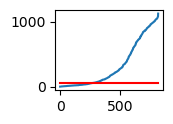

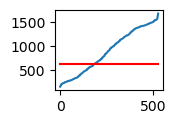

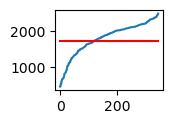

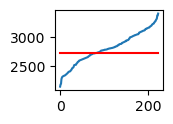

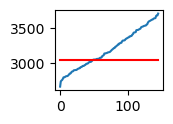

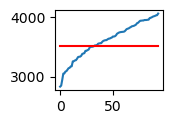

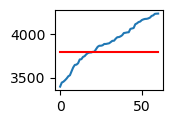

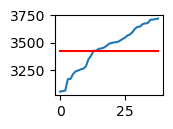

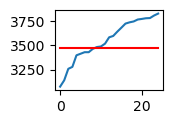

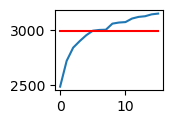

In [35]:
filter_data = cdata
filter_gene_list = gene_names
for i in range(16):
    plt.subplot(4, 4, i+1)
    quantile_cutoff = 0.25 + 0.02 * i
    quantile_cutoff = 0.35
    filter_data, filter_gene_list, new_bins = filter_features_for_sasr(filter_data, filter_gene_list, 5, 2, len(cdata), quantile_cutoff)
    if new_bins is None or len(filter_data) <= 15:
        break
    plt.show()

In [36]:
len(filter_data)

10

In [37]:
type(filter_data)

tensorflow.python.framework.ops.EagerTensor

In [38]:
feature_inds = []
for i in range(len(filter_data)):
    for j in range(i + 1, len(filter_data)):
        for k in range(j + 1, len(filter_data)):
            for l in range(k + 1, len(filter_data)):
                for m in range(l + 1, len(filter_data)):
                    feature_inds += [[i, j, k, l, m]]
feature_inds = tf.constant(feature_inds, tf.int32)
feature_inds.shape

TensorShape([252, 5])

In [39]:
ndim = 2
explanation_of_variance = []
princomp_1 = []
batch_size = 1024 * 64
for i in range(0, len(feature_inds), batch_size):
    limit_i = min(len(feature_inds), i + batch_size)
    u, s, v = np.linalg.svd(tf.gather(filter_data, feature_inds[i:limit_i]).numpy(), full_matrices=False)
    # s, u, _ = tf.linalg.svd(tf.gather(filter_data, feature_inds[i:limit_i]).numpy())
    # Maybe consider ndim = 2 for norming multiple singular values together
    explanation_of_variance.append(np.sum(np.square(s[:, 0:ndim]), axis=-1))
    princomp_1.append(u[:, :, 0:ndim])

In [40]:
explanation_of_variance = np.concatenate(explanation_of_variance, axis=0)
princomp_1 = np.concatenate(princomp_1, axis=0)

In [41]:
opt = np.argmax(explanation_of_variance)
feature_inds[opt]

<tf.Tensor: shape=(5,), dtype=int32, numpy=array([2, 4, 6, 7, 9], dtype=int32)>

In [42]:
sum(explanation_of_variance >= explanation_of_variance[opt])

1

In [43]:
filter_gene_list[feature_inds[opt]]

array(['"ENSMUSG00000030695"', '"ENSMUSG00000032294"',
       '"ENSMUSG00000059040"', '"ENSMUSG00000063524"',
       '"ENSMUSG00000082062"'], dtype=object)

In [45]:
np.set_printoptions(precision=3)
princomp_1[opt]

array([[-0.446,  0.08 ],
       [-0.45 ,  0.101],
       [-0.462, -0.437],
       [-0.462, -0.435],
       [-0.414,  0.777]], dtype=float32)

| Gene                                                                                         | PC1   | PC2    | Notes                                                                                                                                                                   |
|----------------------------------------------------------------------------------------------|-------|--------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| [Aldoa](https://www.ncbi.nlm.nih.gov/gene/11674)                                             | 0.446 | 0.08   | Cell migration                                                                                                                                                          |
| [Pkm](https://www.ncbi.nlm.nih.gov/gene/18746)                                               | 0.45  | 0.101  | [Animal organ regeneration](http://amigo.geneontology.org/amigo/term/GO:0031100); is found in cerebellum                                                                |
| [Eno1b](https://www.ncbi.nlm.nih.gov/gene/433182)                                            | 0.462 | -0.437 | Very similar to Eno1                                                                                                                                                    |
| [Eno1](https://www.ncbi.nlm.nih.gov/gene/13806)                                              | 0.462 | -0.435 | [Embryonic development](http://amigo.geneontology.org/amigo/term/GO:0001701); is found in cerebellum                                                                    |
| [Ftl2-ps](https://useast.ensembl.org/Mus_musculus/Gene/Summary?db=core;g=ENSMUSG00000082062) | 0.414 | 0.777  | [Abnormal heart morphology phenotype](https://useast.ensembl.org/Mus_musculus/Gene/Phenotype?db=core;g=ENSMUSG00000082062;r=4:125398081-125398632;t=ENSMUST00000118517) |


In [48]:
import sklearn.decomposition

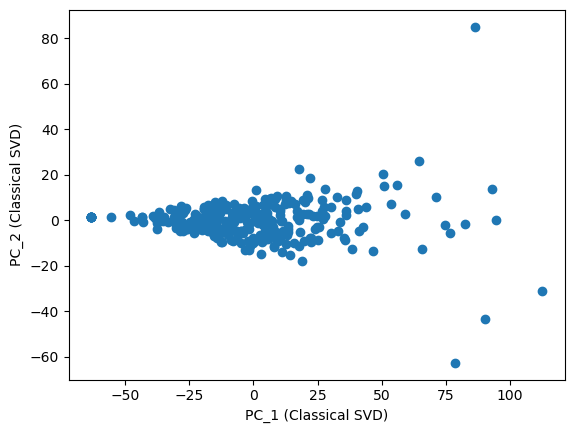

In [90]:
pca_full = sklearn.decomposition.PCA(n_components=2)
classical_pca = pca_full.fit_transform(cdata.numpy().T)
plt.scatter(classical_pca[:, 0], classical_pca[:, 1])
plt.xlabel('PC_1 (Classical SVD)')
plt.ylabel('PC_2 (Classical SVD)')
None

Lasso sparsity k: 576


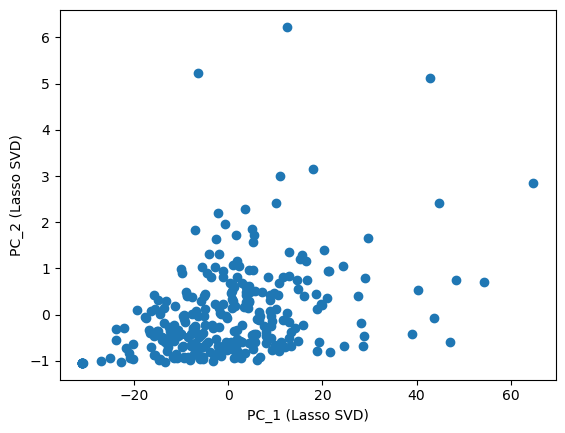

In [91]:
# alpha: L1 sparsity (lasso) penalty.
pca_lasso_sparse = sklearn.decomposition.SparsePCA(n_components=2, alpha=10)
lasso_pca = pca_lasso_sparse.fit_transform(cdata.numpy().T)
print('Lasso sparsity k: {}'.format(sum((np.abs(pca_lasso_sparse.components_) > 1e-10).any(axis=0).astype(int))))
plt.scatter(lasso_pca[:, 0], lasso_pca[:, 1])
plt.xlabel('PC_1 (Lasso SVD)')
plt.ylabel('PC_2 (Lasso SVD)')
None

Text(0, 0.5, 'PC_2 (SASR Feature Selection/L0 SVD)')

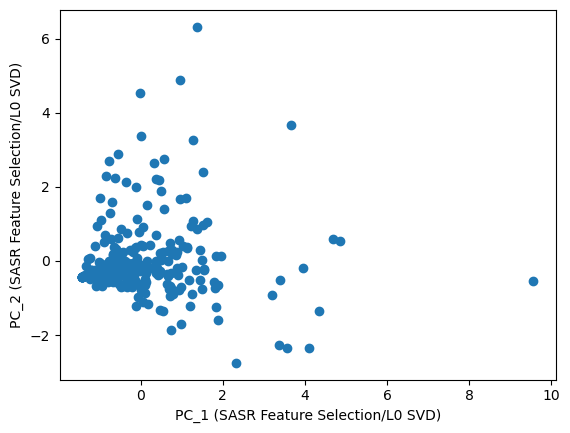

In [92]:
features = tf.gather(cdata, feature_inds[opt]).numpy()
pca_sasr_result = sklearn.decomposition.PCA(n_components=2)
sasr_pca = pca_sasr_result.fit_transform(features.T)
plt.scatter(sasr_pca[:, 0], sasr_pca[:, 1])
plt.xlabel('PC_1 (SASR Feature Selection/L0 SVD)')
plt.ylabel('PC_2 (SASR Feature Selection/L0 SVD)')

### Results

SASR feature selection resulted in a PCA where the PC1 and PC2 components are visually less correlated - there is a process going on along the x-axis, and along the y-axis. SVD always results in an orthonormal basis, so this is just a qualitative finding that could be explored further.

First, we had tried the analysis using ndim = 1, and the gene list was less interpretable (with ndim = 1 it wanted to select a long list of ribosomal proteins). Those genes might be highly variable and there might be an actual process (or noise) going on, but it was hard to call it a success. We would increment ndim (e.g. between 1-3) until we think that the feature selection is selecting something interesting.

### Conclusions

We are using a subroutine that fits into the SASR paper (augment the k rows of data with an additional row, and greedily trim one of the rows). However, we're not using a simulated annealing schedule yet. SASR would select a new row uniformly randomly for its entire duration, and would stochastically move to a less favorable set of rows. It would need to select the unfavorable subdata with the probability ramping lower (`exp(delta_score (1 + alpha*log(T + 1)))`) until it becomes completely greedy. We think that the implementation focus for us is still choosing the distribution of rows to augment as the k+1'th row.

The row sampling still needs to be according to a discrete distribution on every batch, not having the only operation be to chop off rows. At early times, the row sampling can be smoothed towards a uniform distribution even when we have a histogram of observation utility already. We should adjust a multinomial/softmax function of the histogram, so that the differences in our utility score will have most of the rows go to probability 0 with time. Hopefully, runtime to convergence will improve several-fold 

Consider every batch using only a subset of the observations (minibatches). We can also advertise the project as having distributed potential (blocking up the observations and features into several chunks), so that we sum up the contributions from every chunk of the data/every compute node, before the result is effected (the categorical distribution for the next epoch). 

Finally, rank-one SVD updates could be used in more places (even in the final brute-force search) if we had excellent tests and bounds on accuracy.